In [1]:
from config import EPISODE_LEN
from env_utils import get_4wt_symmetric_env
from stable_baselines3 import PPO
import numpy as np
import tqdm

evaluations = 100

2024-10-24 18:31:34.855564: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 18:31:34.947785: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 18:31:35.695602: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 18:31:37.643767: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Evaluate PPO models

In [1]:
def evaluate_model(model, env, evaluations):
    total_rewards = np.zeros((evaluations, EPISODE_LEN))
    total_powers = np.zeros((evaluations, EPISODE_LEN))
    obs, info = env.reset()
    print(len(obs))
    print(info)
    for i in tqdm.tqdm(range(evaluations)):
        for j in range(EPISODE_LEN):
            action, _states = model.predict(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            total_rewards[i, j] = reward
            total_powers[i, j] = info["power_output"]
            if terminated or truncated:
                break
        env.reset()
    return total_rewards, total_powers

models = [
    #("PPO unpriv", PPO.load("ppo_4wt_symmetric_unprivileged_cw_t1000000.0"), None),
    #("PPO priv 75", PPO.load("ppo_4wt_symmetric_privileged_md75_cw_t1000000.0_t1000000.0"), 75)
    ("PPO unpriv alignedreset", PPO.load("data/models/ppo_4wt_symmetric_unprivileged_cw_t1000000.0"), None),
    #?("PPO priv 75 alignedreset", PPO.load("data/models/ppo_4wt_symmetric_privileged_md75_cw_t1000000.0"), 75)
]
for model_name, model, mast_distancing in models:
    privileged = mast_distancing is not None
    env = get_4wt_symmetric_env(
        episode_length=EPISODE_LEN, 
        privileged=privileged, 
        mast_distancing=mast_distancing,
        changing_wind=True,
    )
    rewards, powers = evaluate_model(model, env, evaluations)
    np.save(f"data/{model_name}_rewards.npy", rewards)
    np.save(f"data/{model_name}_powers.npy", powers)

NameError: name 'PPO' is not defined

: 

# Evalute SR proportional controller

In [2]:
from serial_refine_agent import SR_ProportionalController
from env_utils import get_4wt_symmetric_env

# Load agent and environment
agent = SR_ProportionalController()
env = get_4wt_symmetric_env(episode_length=EPISODE_LEN, privileged=False, changing_wind=True, action_representation="yaw")

# Evaluate agent
obs, info = env.reset()
total_rewards = np.zeros((evaluations, EPISODE_LEN))
total_powers = np.zeros((evaluations, EPISODE_LEN))
for i in tqdm.tqdm(range(evaluations)):
    for j in range(EPISODE_LEN):
        wind_direction = env.wind_process.wind_direction
        current_yaws = env.yaws_from_wind

        action = agent.predict(wind_direction, current_yaws)
        obs, reward, terminated, truncated, info = env.step(action)

        total_rewards[i, j] = reward
        total_powers[i, j] = info["power_output"]

        if terminated or truncated:
            break
    env.reset()

np.save("data/SR_proportional_rewards.npy", total_rewards)
np.save("data/SR_proportional_powers.npy", total_powers)

# Evaluate agent in noisy environment
obs, info = env.reset()
total_rewards = np.zeros((evaluations, EPISODE_LEN))
total_powers = np.zeros((evaluations, EPISODE_LEN))
for i in tqdm.tqdm(range(evaluations)):
    for j in range(EPISODE_LEN):
        wind_direction = env.wind_process.wind_direction
        current_yaws = env.yaws_from_wind

        # Add noise to wind direction
        wind_direction = wind_direction + np.random.normal(0, 5)

        action = agent.predict(wind_direction, current_yaws)
        obs, reward, terminated, truncated, info = env.step(action)

        total_rewards[i, j] = reward
        total_powers[i, j] = info["power_output"]

        if terminated or truncated:
            break
    env.reset()

np.save("data/SR_proportional_noisy_rewards.npy", total_rewards)
np.save("data/SR_proportional_noisy_powers.npy", total_powers)

  7%|▋         | 7/100 [00:21<04:40,  3.02s/it]/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:209: RuntimeWarning: invalid value encountered in sqrt
  ln_deltaNum = (1.6 + np.sqrt(M0)) * (
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:210: RuntimeWarning: invalid value encountered in sqrt
  1.6 * np.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0)) - np.sqrt(M0)
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:212: RuntimeWarning: invalid value encountered in sqrt
  ln_deltaDen = (1.6 - np.sqrt(M0)) * (
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:213: RuntimeWarning: invalid value encountered in sqrt
  1.6 * np.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0)) + np.sqrt(M0)
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/flori

# Plot comparisons

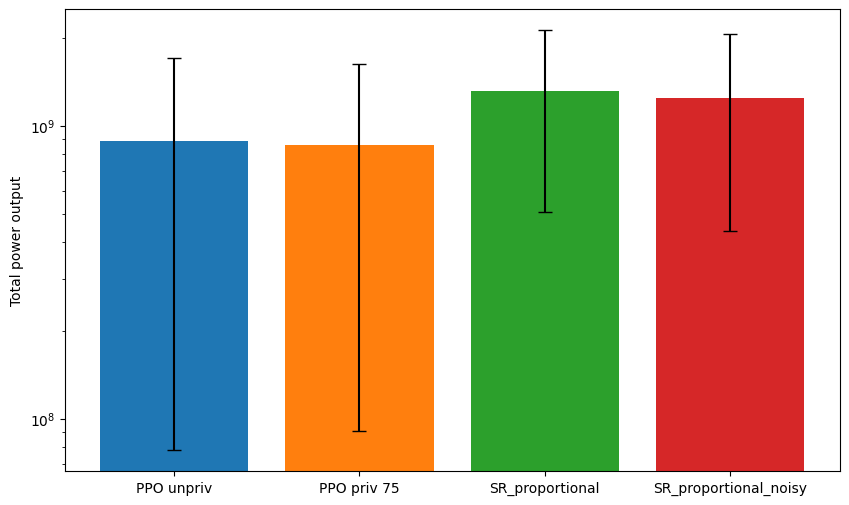

In [4]:
import matplotlib.pyplot as plt
import numpy as np

models = ["PPO unpriv", "PPO priv 75", "SR_proportional", "SR_proportional_noisy"] # "PPO unpriv alignedreset",

# Plot power for each model as barplot, make figure a bit long
plt.figure(figsize=(10, 6))
ax = plt.gca()
for model in models:
    powers = np.load(f"data/{model}_powers.npy")
    ep_powers = powers.sum(axis=1)
    ax.bar(model, ep_powers.mean(), yerr=ep_powers.std(), capsize=5)
plt.ylabel("Total power output")
# Set the y axis to be between 1e10 and 1e8
plt.yscale("log")
plt.show()

In [54]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("maranc/thesis_tests")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

flat_df = {}

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df.to_csv("project.csv")
print(summary_list[100].keys(), config_list[100].keys())

dict_keys(['_runtime', '_step', '_timestamp', '_wandb.runtime', 'eval/total_power', 'eval/total_power_max', 'eval/total_power_min', 'eval/total_power_std', 'eval/total_reward', 'eval/total_reward_max', 'eval/total_reward_min', 'eval/total_reward_std', 'global_step', 'gradients/action_net.bias', 'gradients/action_net.weight', 'gradients/log_std', 'gradients/mlp_extractor.policy_net.0.bias', 'gradients/mlp_extractor.policy_net.0.weight', 'gradients/mlp_extractor.policy_net.2.bias', 'gradients/mlp_extractor.policy_net.2.weight', 'gradients/mlp_extractor.value_net.0.bias', 'gradients/mlp_extractor.value_net.0.weight', 'gradients/mlp_extractor.value_net.2.bias', 'gradients/mlp_extractor.value_net.2.weight', 'gradients/value_net.bias', 'gradients/value_net.weight', 'parameters/action_net.bias', 'parameters/action_net.weight', 'parameters/log_std', 'parameters/mlp_extractor.policy_net.0.bias', 'parameters/mlp_extractor.policy_net.0.weight', 'parameters/mlp_extractor.policy_net.2.bias', 'param

78        PPO_4wt_symmetric_unprivileged_cw_1.00M
68     PPO_4wt_symmetric_privileged_md25_cw_1.00M
73     PPO_4wt_symmetric_privileged_md50_cw_1.00M
71     PPO_4wt_symmetric_privileged_md75_cw_1.00M
72    PPO_4wt_symmetric_privileged_md100_cw_1.00M
70    PPO_4wt_symmetric_privileged_md125_cw_1.00M
69    PPO_4wt_symmetric_privileged_md150_cw_1.00M
Name: name, dtype: object


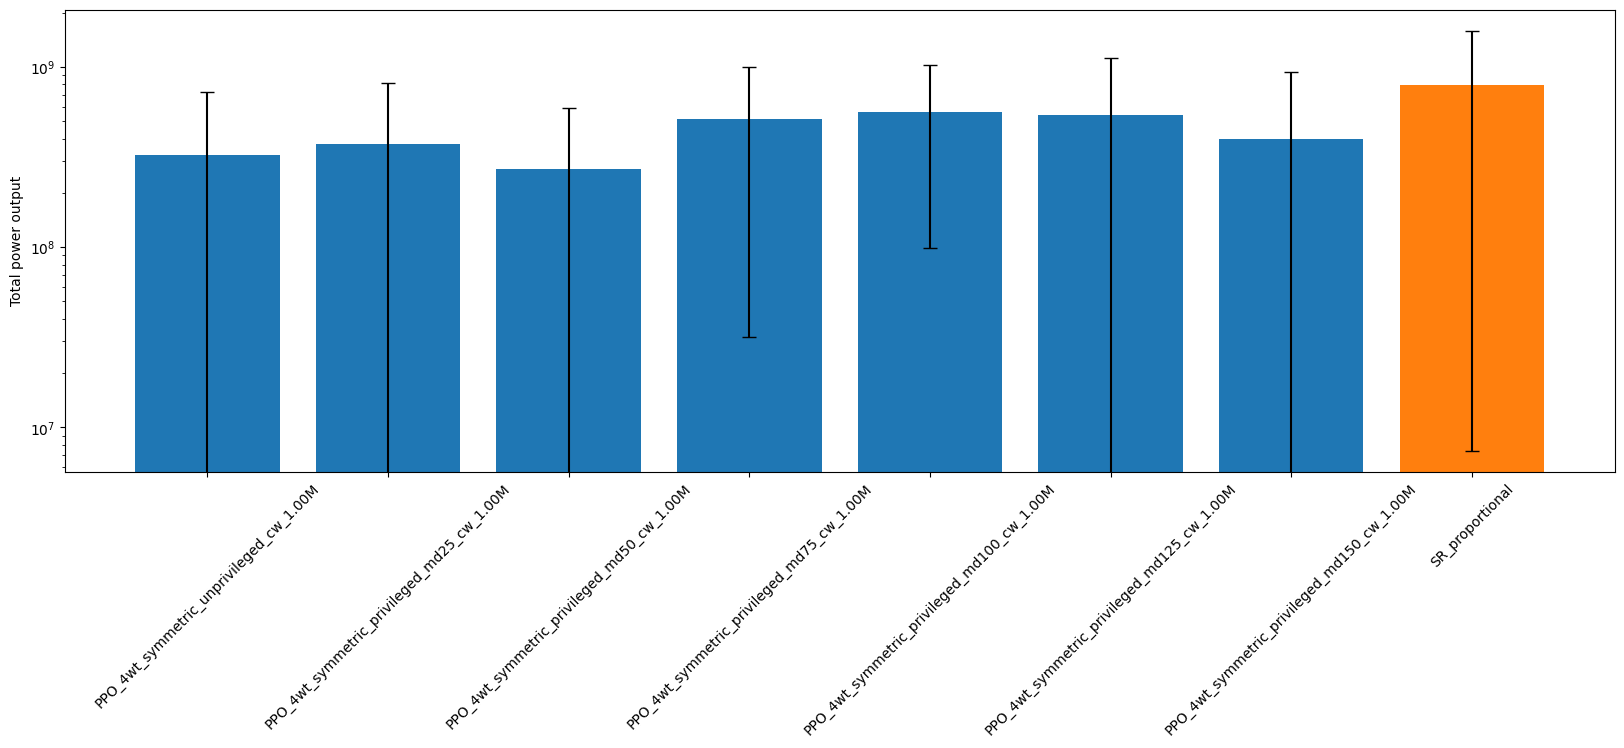

In [61]:
# Get PPO, 4wt_symmetric runs 
ppo_df = pd.DataFrame(summary_list)
ppo_df["name"] = name_list
for k in config_list[100].keys():
    column = []
    for c in config_list:
        if k in c.keys():
            column.append(c[k])
        else:
            column.append(None)
    ppo_df[k] = column

# filter where PPO_4wt in name
ppo_df = ppo_df[ppo_df["experiment_name"].str.contains("PPO_4wt")]
ppo_df = ppo_df[ppo_df["experiment_name"].str.contains("_cw_1.00M")]
ppo_df = ppo_df[~ppo_df["experiment_name"].str.contains("True")]
ppo_df = ppo_df.dropna(subset=["eval/total_power"])

# sort by mast distancing
#order = ["PPO_4wt_symmetric_privileged_md100_cw_1.00M", "PPO_4wt_symmetric_privileged_md125_cw_1.00M", "PPO_4wt_symmetric_privileged_md150_cw_1.00M", "PPO_4wt_symmetric_privileged_md25_cw_1.00M", "PPO_4wt_symmetric_privileged_md50_cw_1.00M", "PPO_4wt_symmetric_privileged_md75_cw_1.00M", "PPO_4wt_symmetric_unprivileged_cw_1.00M",]
ppo_df = ppo_df.sort_values(by="mast_distancing")

print(ppo_df["name"])

power = ppo_df["eval/total_power"]
std = ppo_df["eval/total_power_std"]

# plot
# add legend with colors
plt.figure(figsize=(20, 6))
ax = plt.gca()
ax.bar(ppo_df["name"], power, yerr=std, capsize=5)

powers = np.load(f"data/SR_proportional_powers.npy")
ep_powers = powers.sum(axis=1)
ax.bar("SR_proportional", ep_powers.mean(), yerr=ep_powers.std(), capsize=5)


plt.xticks(rotation=45)
plt.ylabel("Total power output")
plt.yscale("log")
plt.show()

## Run on lhs too

  0%|          | 0/100 [00:00<?, ?it/s]/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:209: RuntimeWarning: invalid value encountered in sqrt
  ln_deltaNum = (1.6 + np.sqrt(M0)) * (
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:210: RuntimeWarning: invalid value encountered in sqrt
  1.6 * np.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0)) - np.sqrt(M0)
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:212: RuntimeWarning: invalid value encountered in sqrt
  ln_deltaDen = (1.6 - np.sqrt(M0)) * (
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:213: RuntimeWarning: invalid value encountered in sqrt
  1.6 * np.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0)) + np.sqrt(M0)
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simula

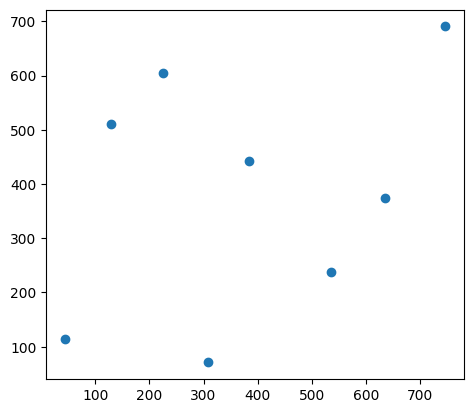

In [6]:
from serial_refine_agent import SR_ProportionalController
from env_utils import get_4wt_symmetric_env, get_lhs_env

# Load agent and environment
agent = SR_ProportionalController(
    wind_directions=np.load("data/serial_refine/lhs8_wind_direction.npy"),
    optimal_yaws=np.load("data/serial_refine/lhs8_yaw_angles_opt.npy"),
)
env = get_lhs_env(
    layout_name="lhs_env_nt8_md150_wb750x750", 
    episode_length=EPISODE_LEN, 
    changing_wind=True, 
    privileged=False,
)
def evaluate_SR_controller(agent, env, evaluations, name):
    # Evaluate agent
    obs, info = env.reset()
    total_rewards = np.zeros((evaluations, EPISODE_LEN))
    total_powers = np.zeros((evaluations, EPISODE_LEN))
    for i in tqdm.tqdm(range(evaluations)):
        for j in range(EPISODE_LEN):
            wind_direction = env.wind_process.wind_direction
            current_yaws = env.yaws_from_wind

            action = agent.predict(wind_direction, current_yaws)
            obs, reward, terminated, truncated, info = env.step(action)

            total_rewards[i, j] = reward
            total_powers[i, j] = info["power_output"]

            if terminated or truncated:
                break
        env.reset()

    np.save(f"data/SR_proportional_{name}_rewards.npy", total_rewards)
    np.save(f"data/SR_proportional_{name}_powers.npy", total_powers)

    # Evaluate agent in noisy environment
    obs, info = env.reset()
    total_rewards = np.zeros((evaluations, EPISODE_LEN))
    total_powers = np.zeros((evaluations, EPISODE_LEN))
    for i in tqdm.tqdm(range(evaluations)):
        for j in range(EPISODE_LEN):
            wind_direction = env.wind_process.wind_direction
            current_yaws = env.yaws_from_wind

            # Add noise to wind direction
            wind_direction = wind_direction + np.random.normal(0, 5)

            action = agent.predict(wind_direction, current_yaws)
            obs, reward, terminated, truncated, info = env.step(action)

            total_rewards[i, j] = reward
            total_powers[i, j] = info["power_output"]

            if terminated or truncated:
                break
        env.reset()

    np.save(f"data/SR_proportional_{name}_noisy_rewards.npy", total_rewards)
    np.save(f"data/SR_proportional_{name}_noisy_powers.npy", total_powers)

evaluate_SR_controller(agent, env, evaluations, "lhs8")

  4%|▍         | 4/100 [00:56<22:40, 14.17s/it]/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:209: RuntimeWarning: invalid value encountered in sqrt
  ln_deltaNum = (1.6 + np.sqrt(M0)) * (
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:210: RuntimeWarning: invalid value encountered in sqrt
  1.6 * np.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0)) - np.sqrt(M0)
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:212: RuntimeWarning: invalid value encountered in sqrt
  ln_deltaDen = (1.6 - np.sqrt(M0)) * (
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:213: RuntimeWarning: invalid value encountered in sqrt
  1.6 * np.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0)) + np.sqrt(M0)
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/flori

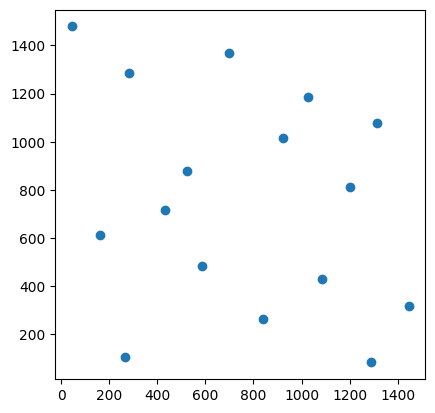

In [7]:
agent = SR_ProportionalController(
    wind_directions=np.load("data/serial_refine/lhs16_wind_direction.npy"),
    optimal_yaws=np.load("data/serial_refine/lhs16_yaw_angles_opt.npy"),
)
env = get_lhs_env(
    layout_name="lhs_env_nt16_md75_wb1500x1500", 
    episode_length=EPISODE_LEN, 
    changing_wind=True,
    privileged=False,
)
evaluate_SR_controller(agent, env, evaluations, "lhs16")